In [1]:
import os,trimesh,re
import numpy as np
from scipy.sparse import lil_matrix
from scipy.sparse.linalg import lsmr

In [152]:
def loadObj(file):
    obj = {}
    obj['v'],obj['vn'],obj['vt'],obj['f'] = [],[],[],[]
    f = open(file, "r")
    lines = f.readlines()
    delimiters = " ", "//", "\\","/","\\"
    regexPattern = '|'.join(map(re.escape, delimiters))
    for item in lines:
        data = re.split(regexPattern, item)
        if 'v' == data[0]:
            obj['v'].append(np.array(data[1:]).astype('float'))
        elif 'vt' == data[0]:
            obj['vt'].append(np.array(data[1:]).astype('float'))
        elif 'vn' == data[0]:
            obj['vn'].append(np.array(data[1:]).astype('float'))
        elif 'f' == data[0]:
            obj['f'].append(np.array(data[1:]).astype('int32'))
    
    hasVN,hasVT = False,False
    if len(obj['v']):
        obj['v'] = np.vstack(obj['v'])
    if len(obj['vn']):
        hasVN = True
        obj['vn'] = np.vstack(obj['vn'])
    if len(obj['vt']):
        hasVT = True
        obj['vt'] = np.vstack(obj['vt'])
    if len(obj['f']):
        obj['f'] = np.vstack(obj['f'])
    
    f = np.ones((9,obj['f'].shape[0]))
    if  hasVN and hasVT:
        f = obj['f'][:,[0,3,6,2,5,8,1,4,7]].T
    elif hasVN and obj['f'].shape[1]==6:
        f[:6] = obj['f'][:,[0,2,4,1,3,5]].T
    elif hasVT and obj['f'].shape[1]==6:
        f[[0,1,2,6,7,8]] = obj['f'][:,[0,2,4,1,3,5]].T
    else:
        f[[0,1,2]] = obj['f'].T
    obj['f'] = f.astype('uint32')-1
    return obj

def load_vertice_only(file):
    f = open(file, "r")
    lines = f.readlines()
    delimiters = " ", "//", "\\","/","\\"
    regexPattern = '|'.join(map(re.escape, delimiters))
    V = []
    for item in lines:
        data = re.split(regexPattern, item)
        if 'v' == data[0]:
            V.append(np.array(data[1:]).astype('float'))
    f.close()
    return np.stack(V,axis=0)

def build_local_frames(verticess,faces):
    Ms = []
    for vertice in verticess:
        M = []
        for item in faces:
            v = vertices[item]
            edge1,edge2 = v[2]-v[0],v[1]-v[0]
            n = np.cross(edge1,edge2)
            M.append(np.stack((edge1,edge2,n),axis=1))
        Ms.append(np.stack(M,axis=0))
    return np.stack(Ms,axis=0)

def build_local_frame(vertices,faces):
    M = []
    for item in faces:
        v = vertices[item]
        edge1,edge2 = v[2]-v[0],v[1]-v[0]
        n = np.cross(edge1,edge2)
        M.append(np.stack((edge1,edge2,n),axis=1))
    return np.stack(M,axis=0)

def inv_M(M):
    M_inv = []
    for item in M:
        M_inv.append(np.linalg.inv(item))
    return np.stack(M_inv,axis=0)

def build_G(M_s_inv,M_t):
    G = []
    for t,s in zip(M_t,M_s_inv):
        G.append(np.dot(t,s))
    return np.stack(G,axis=0)

def build_Gs(Ms):
    M_0_inv = inv_M(Ms[0])
    Gs = []
    for item in Ms:
        Gs.append(build_G(M_0_inv,item))
    return np.stack(Gs,axis=0)

def reconstruct_M_from_G(M_0, Gs):
    Ms = []
    for G in Gs:
        M = []
        for m,g in zip(M_0,G):
            M.append(np.dot(g,m))
        Ms.append(np.stack(M,axis=0))
    return np.stack(Ms,axis=0)

def reconstruct_shape_from_Ms(number_vertex,faces, Ms):
    shape = []
    for M in Ms:
        shape.append(reconstruct_shape_from_M(number_vertex,faces, M))
    return np.stack(shape,axis=0)

def reconstruct_shape_from_M(number_vertex,faces, M):
    number_face = faces.shape[0]
    A = lil_matrix((6*number_face,3*number_vertex))
    b = np.zeros(6*number_face)

    for i in range(number_face):
        idx = faces[i]
        for j in range(3):
            A[6*i+j,3*idx[2]+j],A[6*i+j,3*idx[0]+j] = 1,-1
            A[6*i+j+3,3*idx[1]+j],A[6*i+j+3,3*idx[0]+j] = 1,-1
        
            b[6*i+j],b[6*i+j+3] = M[i,j,0],M[i,j,1]
    x = lsmr(A,b)[0]
    return x

def head_to_face(filePath):
    mesh = loadObj(filePath)
    mask = np.zeros(mesh['v'].shape[0]).astype('bool')
    for face in mesh['f'][:3].T:
        mask[face] = 1
    
    remap = -np.ones(mesh['v'].shape[0]).astype('int')
    if mask[0]:
        remap[0] = 0
    for i in range(1,mesh['v'].shape[0]):
        remap[i] = remap[i-1]+mask[i]
    face = remap[mesh['f'][:3]].T
    return mask,face

def solve_alpha(M_S,M_B):
    alphas = []
    number_face,number_blendshape,number_sourse = M_B.shape[1],M_B.shape[0]-1,M_S.shape[0]-1
    for k in range(number_sourse):
        A = np.zeros((6*number_face,number_blendshape))
        b = np.zeros(number_blendshape)
        
        for i in range(number_face):
            for j in range(number_blendshape):
                A[6*i:6*(i+1),j] = M_B[j+1,i,:,:2].reshape((-1))
        b = (M_S[k+1] - M_S[0])[:,:2].reshape((-1))
        x = lsmr(A,b)[0]
        alphas.append(x)
    return np.stack(alphas,axis=0)

def solve_alpha_from_blendshape(S,B):
    '''
    S: N * vertice
    B: M * vertice
    '''
    alphas = []
    B_temp = B[1:] - B[[0]]
    number_vertices,number_blendshape,number_sourse = B.shape[1]//3,B.shape[0]-1,S.shape[0]
    for k in range(number_sourse):
        b = (S[k]-B[0]).reshape((-1))
        x = lsmr(B_temp.T,b)[0]
        alphas.append(x)
    return np.stack(alphas,axis=0)

def solve_M_from_alpha(M_S, alpha, M_B_hat):
    number_face, number_blendshape,number_sourse = M_S.shape[1], alpha.shape[1],alpha.shape[0]
    B = M_S - M_B_hat[[0]]
    omega = np.linalg.norm(M_B_hat[...,:2], axis=(2,3))
    omega = ((1+omega)/(0.1+omega))**2
    M = []
    for i in range(number_face):

        A = np.zeros((number_sourse*6+number_blendshape*6,number_blendshape*6))
        b = np.zeros(number_sourse*6+number_blendshape*6)
        for j in range(6):
            A[number_sourse*j:number_sourse*(j+1),number_blendshape*j:number_blendshape*(j+1)] = alpha
        b[:number_sourse*6] = B[:,i,:,:2].reshape((-1),order='F')
        
        M_B_hat_sub = M_B_hat[:,i,:,:2]
        star = number_sourse*6
        A[star:star+6*number_blendshape] = np.eye(6*number_blendshape)#np.diag(omega[1:,[i]].repeat(6,axis=1).reshape(-1,order='F'))
        b[star:star+6*number_blendshape] = M_B_hat_sub[1:].reshape((-1),order='F')
        
        x = lsmr(A,b)[0]
        M.append(x.reshape((-1,3,2),order='F'))
    return np.stack(M,axis=1)
        
        
def reconstruct_M_from_alpha(alpha,M_B):
    shape = M_B.shape
    temp = np.repeat(alpha.reshape((-1,1)),shape[1]*shape[2]*shape[3],axis=1).reshape((-1,shape[1],shape[2],shape[3]))
    return M_B[0] +  np.sum(temp * M_B[1:],axis=0)

def reconstruct_shape_from_alpha(alpha,B):
    shape = B.shape
    temp = np.repeat(alpha.reshape((-1,1)),shape[1],axis=1)
    return B[0] +  np.sum(temp * B[1:],axis=0)

def preprocess_data(M_S,number_vertex,faces):
    S = []
    for item in M_S:
        S.append(reconstruct_shape_from_M(number_vertex,faces, item))
    return np.stack(S,axis=0)

In [10]:
M_S = []
root = './Tester/TrainingPose/'
vertice_mask,face = head_to_face('./Tester/shape_0.obj')
# for i in range(20):
#     vertices = load_vertice_only(os.path.join(root,'pose_%d.obj'%i))[vertice_mask]
#     M_S.append(build_local_frame(vertices,face))
# M_S = np.stack(M_S,axis=0)
# S = preprocess_data(M_S,M_S[0].shape[0],face)
# sourceshape_path = 'E:/mesh2face/pose_estimation/Tester_1/source_models.npy'
# np.save(sourceshape_path,{'M_S':M_S,'S':S})
    
# M_A = []
# root = 'E:/mesh2face/pose_estimation/Tester_1/mean/'
# for i in range(47):
#     vertices = load_vertice_only(os.path.join(root,'shape_%d.obj'%i))
#     M_A.append(build_local_frame(vertices,face))
# M_A = np.stack(M_A,axis=0)
# A = preprocess_data(M_A,M_A[0].shape[0],face)
# G_A = build_Gs(M_A)
# np.save(blendshape_path,{'M_A':M_A,'G_A':G_A,'A':A})

sourceshape_path = './Tester/source_models.npy'
source_model = np.load(sourceshape_path, allow_pickle=True)[()]
M_S, S = source_model['M_S'],source_model['S']

blendshape_path = './Tester/exp_blendshape.npy'
blendshape = np.load(blendshape_path, allow_pickle=True)[()]
M_A, G_A, A = blendshape['M_A'],blendshape['G_A'],blendshape['A']

In [252]:
number_vertex = A.shape[1]/3
M_B_hat = reconstruct_M_from_G(M_S[0], G_A)
B_hat = reconstruct_shape_from_Ms(number_vertex,face,M_B_hat)
alpha = solve_alpha_from_blendshape(S,B_hat)
B_hat_0 = B_hat[[0]]
for iter in range(2):
    M_B = solve_M_from_alpha(M_S, alpha, M_B_hat)
    B_hat = reconstruct_shape_from_Ms(number_vertex,face,M_B)
    B_hat = np.vstack((B_hat_0,B_hat))
    alpha = solve_alpha_from_blendshape(S,B_hat)

mesh = trimesh.load('./Tester/shape_0.obj')
mesh.faces = face
for i,item in enumerate(B_hat):
    mesh.vertices = item.reshape((-1,3))
    mesh.export('result/result_blendshape_%02d.obj'%i);

In [130]:
alpha = solve_alpha_from_blendshape(S[[1]],B_hat)
# M_recon = reconstruct_M_from_alpha(alpha[0],M_B_hat)
x = reconstruct_shape_from_alpha(alpha,B_hat)
# x = reconstruct_shape_from_M(number_vertex,face,M_recon)
mesh.vertices = x.reshape((-1,3))
mesh.export('test2.obj');

In [151]:
mesh.vertices = reconstruct_shape_from_Ms(number_vertex,face,M_B[[0]]).reshape((-1,3))
mesh.export('test.obj');

In [126]:
# M_recon = reconstruct_M_from_alpha(alpha[0],M_B_hat)
# x = reconstruct_shape_from_M(number_vertex,face,M_recon)
mesh.vertices = S[[1]].reshape((-1,3))
mesh.export('test.obj');

In [220]:
# Ms = reconstruct_M_from_G(M_A[0],G_A)
number_vertex = vertices.shape[0]
x = reconstruct_shape_from_M(number_vertex,face,M_A[0])
mesh2.vertices = x.reshape((-1,3))
mesh2.export('test.obj');

In [219]:
mesh2.vertices = S[0].reshape((-1,3))
mesh2.export('test.obj');

In [225]:
root = 'E:/faceWrap/FaceWarehouse_Data_0/'
for j in range(47):
    for i in range(1,151):   
        file = os.path.join(root,'Tester_%d/Blendshape/shape_%d.obj'%(i,j))
        vertices = load_vertice_only(file)[vertice_mask]
        if 1 == i:
            obj = vertices
        else:
            obj += (vertices - obj)/i
    mesh2.vertices = obj
    mesh2.export(os.path.join(root,'mean/shape_%d.obj'%j));

In [306]:
point = np.load('E:/face2face3/1a04e3eab45ca15dd86060f189eb133/pointcloud.npz')
camera = np.load('E:/face2face3/1a04e3eab45ca15dd86060f189eb133/img_choy2016/cameras.npz')
affine = np.dot(camera['camera_mat_%d' % 0],camera['world_mat_%d' % 0])

In [315]:
img_coordinate = np.dot(affine[:3,:3],point['scale']*point['points'].T)+affine[:3,[3]]
img_coordinate[0] /= img_coordinate[2]
img_coordinate[1] /= img_coordinate[2]
img_coordinate = np.round(img_coordinate).astype('int')
img = np.zeros((137,137))
img[img_coordinate[1],img_coordinate[0]]=1

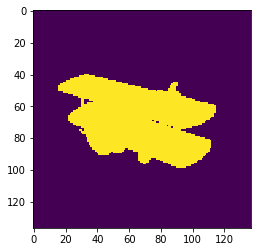

In [318]:
plt.imshow(img)